### Silver to Gold Medallion Layer: Merging Data Sources

In [1]:
import sys
sys.path.append("..")

In [2]:
from snowflake.snowpark import Session
from snowflake.snowpark.functions import when, col, count, sum
from datetime import date
from helpers import SnowflakeHelper
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
null_value_mapping = {
    "(null)" : None,
    "NaN" : None,
    "(" : None,
    "NULL": None,
    "(nu": None, 
    "#N/A": None
}

In [4]:
snowflake_helper = SnowflakeHelper("SAFEGUARDING_NYC_SCHEMA_SILVER")
snowflake_config = './../helpers/snowflake_config.json'
session = snowflake_helper.create_snowpark_session(snowflake_config)

[INFO] Using the schema SAFEGUARDING_NYC_SCHEMA_SILVER for the session
[SUCCESS] Config file loaded successfully!
[SUCCESS] Snowspark Session created successfully on schema SAFEGUARDING_NYC_SCHEMA_SILVER!


## Extracting Data

In [5]:
use_of_force_data = session.table('SAFEGUARDING_NYC_SCHEMA_GOLD.USE_OF_FORCE_COMBINED')
sqf_data = session.table('SQF_DATA')
shooting_incidents_data = session.table('SHOOTING_INCIDENTS')

In [6]:
use_of_force_data.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"FORCETYPE"        |"INCIDENT PCT"  |"TRI INCIDENT NUMBER"  |"PATROL BOROUGH"  |"OCCURRENCE DATE"  |"FORCE AGAINST MOS"  |"AGE"  |"SUBJECT GENDER"  |"SUBJECT RACE"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------
|Physical Force     |1               |2020020962067          |MANHATTAN         |2020-05-06         |Physical Force       |NULL   |MALE              |BLACK           |
|Physical Force     |1               |2020020962143          |MANHATTAN         |2020-10-11         |Physical Force       |NULL   |MALE              |BLACK           |
|Physical Force     |5               |2020024962080          |MANHATTAN         |2020-06-30         |Physical Force       |NULL   |MALE              |BLACK     

In [7]:
sqf_data.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [8]:
shooting_incidents_data.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"OCCUR_DATE"  |"OCCUR_TIME"  |"INCIDENT_KEY"  |"LATITUDE"   |"STATISTICAL_MURDER_FLAG"  |"LONGITUDE"   |"BORO"     |"LOCATION_DESC"            |"PRECINCT"  |"PERP_AGE_GROUP"  |"VIC_AGE_GROUP"  |"VIC_RACE"      |"PERP_RACE"     |"PERP_SEX"  |"VIC_SEX"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|2007-05-04    |19:13:00      |28832628        |40.70370632  |FALSE                      |-73.94325706  |BROOKLYN   |MULTI DWELL - PUBLIC HOUS  |90          |<18               |<18              |BLACK           |BLACK           |MALE  

In [9]:
sqf_df = sqf_data.toPandas()
sqf_df.head(5)

,STOP_ID,STOP_FRISK_TIME,SUPERVISING_ACTION_CORRESPONDING_ACTIVITY_LOG_ENTRY_REVIEWED,SUSPECT_WEIGHT,STOP_LOCATION_SECTOR_CODE,STOP_LOCATION_STREET_NAME,STOP_DURATION_MINUTES,SUSPECT_SEX,ASK_FOR_CONSENT_FLG,STOP_LOCATION_X,...,SEARCH_BASIS_OUTLINE_FLAG,ISSUING_OFFICER_RANK,OFFICER_EXPLAINED_STOP_FLAG,STOP_LOCATION_PRECINCT,SUSPECT_OTHER_DESCRIPTION,STOP_LOCATION_PATROL_BORO_NAME,STOP_LOCATION_BORO_NAME,YEAR2,SUSPECT_RACE_DESCRIPTION,STOP_FRISK_DATE
0,1,01:50:00,Y,200,B,JENNINGS ST,2,MALE,N,1013737,...,None,SGT,Y,042,None,BRONX,BRONX,2021,BLACK,2021-01-01
1,2,10:55:00,Y,160,B,219 ST,10,MALE,N,1052511,...,None,POM,Y,105,NA,QUEENS,QUEENS,2021,BLACK,2021-01-01
2,3,10:10:00,N,None,A,151 AVE,1,MALE,None,1025662,...,None,POM,Y,106,YELLOW SWEATER,QUEENS,QUEENS,2021,ASIAN/PACIFIC ISLANDER,2021-01-01
3,4,20:17:00,Y,180,A,BROADWAY,5,MALE,Y,1010122,...,None,POM,Y,073,None,BROOKLYN,BROOKLYN,2021,BLACK,2021-01-01
4,5,19:59:00,Y,185,C,W 125 ST,30,MALE,N,996623,...,None,POM,Y,026,UNKNOWN,MANHATTAN,MANHATTAN,2021,BLACK,2021-01-01


In [10]:
sqf_df = sqf_df.replace(null_value_mapping)
sqf_df

,STOP_ID,STOP_FRISK_TIME,SUPERVISING_ACTION_CORRESPONDING_ACTIVITY_LOG_ENTRY_REVIEWED,SUSPECT_WEIGHT,STOP_LOCATION_SECTOR_CODE,STOP_LOCATION_STREET_NAME,STOP_DURATION_MINUTES,SUSPECT_SEX,ASK_FOR_CONSENT_FLG,STOP_LOCATION_X,...,SEARCH_BASIS_OUTLINE_FLAG,ISSUING_OFFICER_RANK,OFFICER_EXPLAINED_STOP_FLAG,STOP_LOCATION_PRECINCT,SUSPECT_OTHER_DESCRIPTION,STOP_LOCATION_PATROL_BORO_NAME,STOP_LOCATION_BORO_NAME,YEAR2,SUSPECT_RACE_DESCRIPTION,STOP_FRISK_DATE
0,1,01:50:00,Y,200,B,JENNINGS ST,2,MALE,N,1013737,...,None,SGT,Y,042,None,BRONX,BRONX,2021,BLACK,2021-01-01
1,2,10:55:00,Y,160,B,219 ST,10,MALE,N,1052511,...,None,POM,Y,105,NA,QUEENS,QUEENS,2021,BLACK,2021-01-01
2,3,10:10:00,N,None,A,151 AVE,1,MALE,None,1025662,...,None,POM,Y,106,YELLOW SWEATER,QUEENS,QUEENS,2021,ASIAN/PACIFIC ISLANDER,2021-01-01
3,4,20:17:00,Y,180,A,BROADWAY,5,MALE,Y,1010122,...,None,POM,Y,073,None,BROOKLYN,BROOKLYN,2021,BLACK,2021-01-01
4,5,19:59:00,Y,185,C,W 125 ST,30,MALE,N,996623,...,None,POM,Y,026,UNKNOWN,MANHATTAN,MANHATTAN,2021,BLACK,2021-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69252,None,23:45:00,None,160,C,EAST TREMONT AVENUE,2,MALE,Y,1015559,...,None,POM,Y,48,N/A,BRONX,BRONX,2019,BLACK,2019-03-06
69253,None,23:45:00,None,160,C,EAST TREMONT AVENUE,2,MALE,Y,1015559,...,None,POM,Y,48,NONE,BRONX,BRONX,2019,BLACK,2019-03-07
69254,None,16:20:00,None,150,A,FORDHAM PLAZA,9,MALE,Y,1014657,...,None,POM,Y,48,N/A,BRONX,BRONX,2019,BLACK HISPANIC,2019-03-08
69255,None,0:20:00,None,200,C,ELSMERE PLACE,30,MALE,N,1015655,...,Y,POM,Y,48,None,BRONX,BRONX,2019,BLACK,2019-03-12


In [11]:
sqf_df['STOP_FRISK_TIME'] = pd.to_datetime(sqf_df['STOP_FRISK_TIME'])
sqf_df['STOP_FRISK_HOUR'] = sqf_df['STOP_FRISK_TIME'].apply(lambda x: x.hour)
sqf_df['STOP_FRISK_HOUR']

/var/folders/7b/79wqm1gs4qx4b_4mdnfyf4kh0000gn/T/ipykernel_52738/1339669683.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sqf_df['STOP_FRISK_TIME'] = pd.to_datetime(sqf_df['STOP_FRISK_TIME'])


0         1.0
1        10.0
2        10.0
3        20.0
4        19.0
         ... 
69252    23.0
69253    23.0
69254    16.0
69255     0.0
69256     1.0
Name: STOP_FRISK_HOUR, Length: 69257, dtype: float64

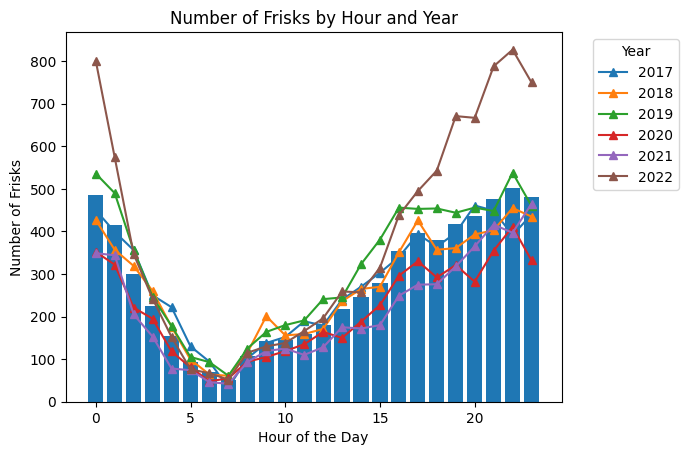

In [12]:
frisk_df = sqf_df[sqf_df['FRISKED_FLAG'] == 'Y']
grouped_df = frisk_df.groupby(['STOP_FRISK_HOUR', 'YEAR2']).size().unstack()
grouped_df['Mean'] = grouped_df.iloc[:, :].mean(axis=1)

for year in grouped_df.columns[:-1]:
    plt.plot(grouped_df.index, grouped_df[year], label=str(year), marker='^')

#plt.plot(grouped_df.index, grouped_df['Mean'], label='Mean', marker='o')
plt.bar(grouped_df.index, grouped_df['Mean'])
# Customize the plot
plt.title('Number of Frisks by Hour and Year')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Frisks')
plt.legend(title='Year', bbox_to_anchor=(1.25, 1), loc='upper right')
plt.show()

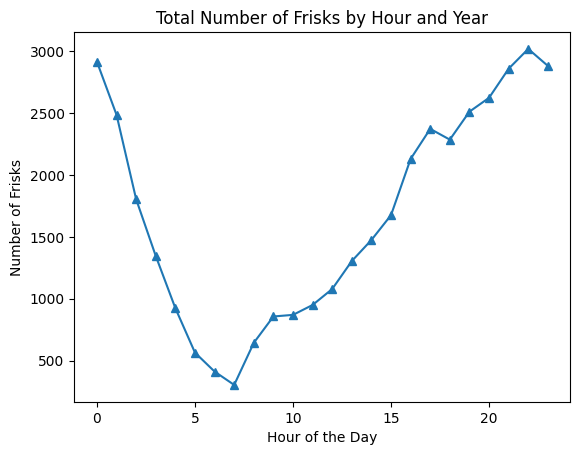

In [13]:
grouped_df = frisk_df.groupby(['STOP_FRISK_HOUR']).size()

plt.plot(grouped_df.index, grouped_df[0:], marker='^')


# Customize the plot
plt.title('Total Number of Frisks by Hour and Year')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Frisks')
plt.show()

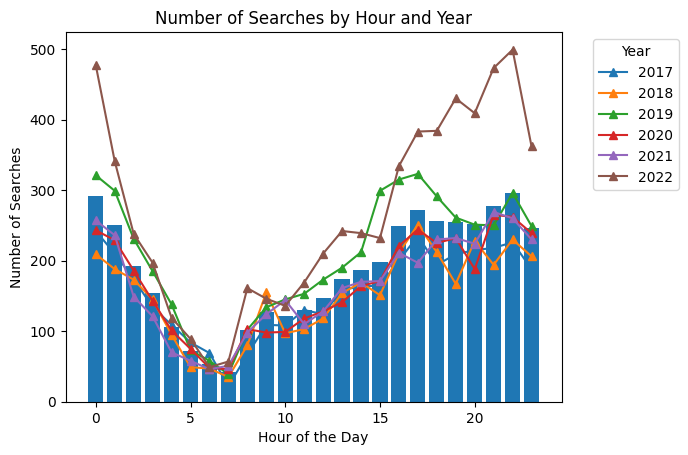

In [14]:
search_df = sqf_df[sqf_df['SEARCHED_FLAG'] == 'Y']
grouped_df = search_df.groupby(['STOP_FRISK_HOUR', 'YEAR2']).size().unstack()
grouped_df['Mean'] = grouped_df.iloc[:, :].mean(axis=1)

for year in grouped_df.columns[:-1]:
    plt.plot(grouped_df.index, grouped_df[year], label=str(year), marker='^')

#plt.plot(grouped_df.index, grouped_df['Mean'], label='Mean', marker='o')
plt.bar(grouped_df.index, grouped_df['Mean'])
# Customize the plot
plt.title('Number of Searches by Hour and Year')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Searches')
plt.legend(title='Year', bbox_to_anchor=(1.25, 1), loc='upper right')
plt.show()

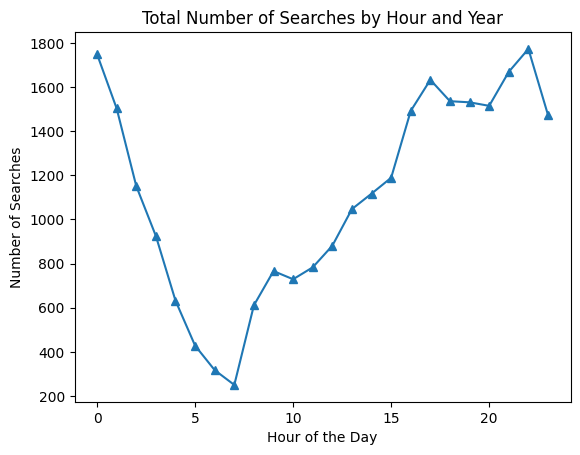

In [15]:
grouped_df = search_df.groupby(['STOP_FRISK_HOUR']).size()

plt.plot(grouped_df.index, grouped_df[0:], marker='^')


# Customize the plot
plt.title('Total Number of Searches by Hour and Year')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Searches')
plt.show()